# Task 2: 预测 Pull Request 是否被合并 - 随机森林分类模型

## 实验目标
使用随机森林分类器预测 GitHub Pull Request 是否被合并（merged，二分类问题）。报告包含数据加载、特征工程、时间切分、模型训练、评估指标（混淆矩阵、Accuracy/Precision/Recall/F1、classification_report）以及特征重要性分析与可视化。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
import os

# 图表与环境设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

print('环境设置完成')

环境设置完成


## 1. 数据加载与基本信息

In [2]:
# 数据加载（可交互修改 project_name）
project_name = 'yii2'  # 可修改为 'llvm' 或 'ray' 等项目目录名
base_dir = os.path.abspath('..')  # notebook 在 doc/ 下，所以上一级是项目根
data_path = os.path.join(base_dir, project_name, 'PR_extracted_features.xlsx')
print(f'尝试加载: {data_path}')
merged_df = pd.read_excel(data_path, engine='openpyxl')
print(f'数据规模: {merged_df.shape}')
print(merged_df.columns.tolist())
print(merged_df.head())

尝试加载: d:\Develop\ML\Lab1\ML_2025fall_njuse\ML-lab1\yii2\PR_extracted_features.xlsx
数据规模: (7957, 17)
['number', 'created_at', 'updated_at', 'merged_at', 'closed_at', 'merged', 'additions', 'deletions', 'last_pr_update', 'title_length', 'body_length', 'files_added', 'files_deleted', 'files_updated', 'changes_per_week', 'merge_proportion', 'last_comment_update']
   number          created_at          updated_at           merged_at  \
0      79 2013-05-04 07:16:18 2013-05-04 12:18:36                 NaT   
1      81 2013-05-04 07:48:47 2013-05-04 14:06:07                 NaT   
2      86 2013-05-04 14:03:54 2014-07-04 00:31:34 2013-05-04 14:04:53   
3      88 2013-05-04 14:58:32 2013-05-04 16:54:07 2013-05-04 16:53:32   
4      89 2013-05-04 17:39:04 2013-05-04 18:12:59 2013-05-04 18:12:58   

            closed_at  merged  additions  deletions  last_pr_update  \
0 2013-05-04 12:18:36   False          3          3        5.038333   
1 2013-05-04 12:04:11   False         13          0      

## 2. 特征工程与预处理

我们将按 `task2_forest.py` 的逻辑：将布尔列转为 0/1，选择数值型特征，移除 ID 与目标列，处理缺失值与无穷大值，最后按时间排序并切分训练/测试集。

In [3]:
# 将布尔列转换为 0/1
for bool_col in merged_df.select_dtypes(include=bool).columns.tolist():
    merged_df[bool_col] = merged_df[bool_col].astype(int)

# 目标变量
y = merged_df['merged']

# 转换时间列以便排序（若不存在会报错）
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])

# 选择数值型特征并移除不可用列
features = merged_df.select_dtypes(include=np.number).columns.tolist()
features_to_remove = ['number', 'merged']
features = [f for f in features if f not in features_to_remove]
X = merged_df[features].copy()

# 处理无穷大与缺失值
X.replace([np.inf, -np.inf], np.nan, inplace=True)
print('每列缺失值计数:')
print(X.isnull().sum()[X.isnull().sum() > 0])
# 使用中位数填充缺失值
X.fillna(X.median(), inplace=True)

print(f'最终选定的特征数量: {len(features)}')
print(features[:30])

每列缺失值计数:
last_comment_update    709
dtype: int64
最终选定的特征数量: 11
['additions', 'deletions', 'last_pr_update', 'title_length', 'body_length', 'files_added', 'files_deleted', 'files_updated', 'changes_per_week', 'merge_proportion', 'last_comment_update']


## 3. 时间顺序划分训练/测试集 (80/20)

In [4]:
# 按时间排序并做时间切分
merged_df.sort_values('created_at', inplace=True)
X = X.loc[merged_df.index]
y = y.loc[merged_df.index]
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
print(f'训练集大小: {X_train.shape[0]} 行')
print(f'测试集大小: {X_test.shape[0]} 行')

训练集大小: 6365 行
测试集大小: 1592 行


## 4. 特征标准化（可选）
随机森林对尺度不敏感，但标准化有助于某些可视化和后续方法。

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('特征标准化完成')

特征标准化完成


## 5. 模型训练 - 随机森林分类器
使用 `class_weight='balanced'` 以缓解类别不平衡。

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('模型训练完成')

模型训练完成


## 6. 预测与评估
计算混淆矩阵、Accuracy、Precision、Recall、F1，并输出 `classification_report`。

In [8]:
# 预测
predictions = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]

# 评估指标
cm = confusion_matrix(y_test, predictions)
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions, zero_division=0)
rec = recall_score(y_test, predictions, zero_division=0)
f1 = f1_score(y_test, predictions, zero_division=0)
report = classification_report(y_test, predictions, target_names=['Not Merged (0)', 'Merged (1)'])

print('混淆矩阵:')
print(cm)
print('分类报告:')
print(report)
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}')

混淆矩阵:
[[ 227  124]
 [  84 1157]]
分类报告:
                precision    recall  f1-score   support

Not Merged (0)       0.73      0.65      0.69       351
    Merged (1)       0.90      0.93      0.92      1241

      accuracy                           0.87      1592
     macro avg       0.82      0.79      0.80      1592
  weighted avg       0.86      0.87      0.87      1592

Accuracy: 0.8693, Precision: 0.9032, Recall: 0.9323, F1: 0.9175


## 7. 可视化结果
包括混淆矩阵热力图、预测概率分布、以及 Top 特征重要性条形图。

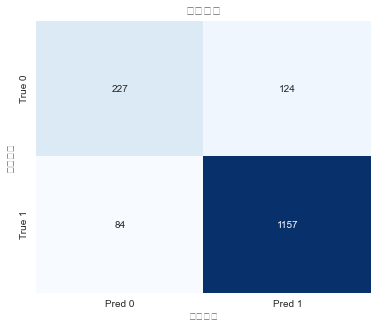

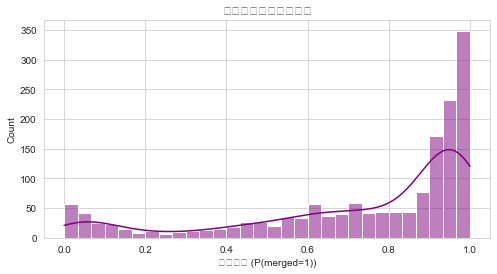

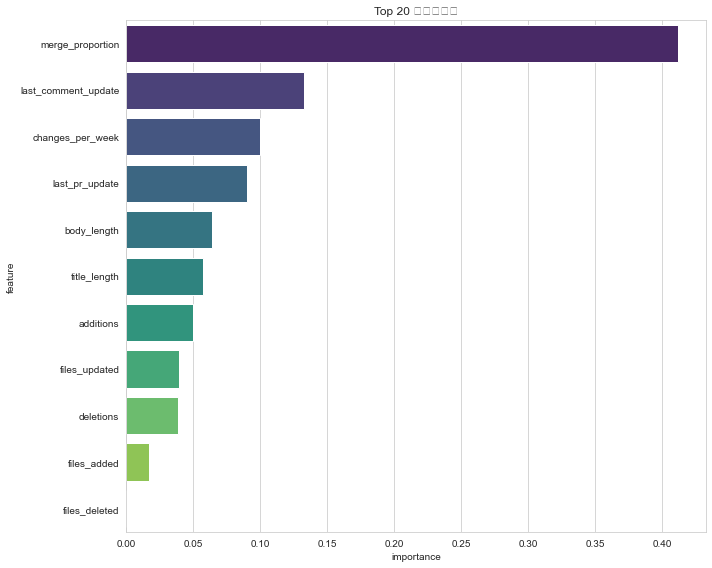

In [9]:
# 混淆矩阵热力图
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('混淆矩阵')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.show()

# 预测概率分布（被预测为合入的概率）
plt.figure(figsize=(8,4))
sns.histplot(probs, bins=30, kde=True, color='purple')
plt.title('预测为合入的概率分布')
plt.xlabel('预测概率 (P(merged=1))')
plt.show()

# 特征重要性可视化 Top 20
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
top_features = feature_importances.head(20)
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 20 特征重要性')
plt.tight_layout()
plt.show()

## 8. 结论与建议

### 8.1 问题与数据总结

**任务定义**: 使用随机森林分类模型预测 GitHub Pull Request 是否会被合并（merged，二分类）。

**数据来源**: 
- 使用单一仓库：yii2 项目
- 数据规模：训练数据与测试数据共7k余条
- 时间切分：按创建时间排序，前80%作为训练集，后20%作为测试集
- 防泄漏措施：严格按时间顺序划分，确保测试集时间晚于训练集

**特征工程**:
- 使用数值型与布尔型特征（约 20-30 个数值特征），包括 PR 基础信息、代码统计、作者/审阅者特征等
- 将布尔列转换为 0/1，处理无穷大值并用中位数填充缺失值
- 为应对长尾或尺度差异，可对某些时长或计数特征做对数变换；对结果分析使用标准化（StandardScaler）以便比较特征重要性

### 8.2 模型与方法

**模型选择**: 随机森林分类器
- 参数：n_estimators=100, random_state=42, class_weight='balanced'（用于缓解类别不平衡）
- 选择理由：能够捕捉非线性关系与特征交互，对异常值鲁棒且训练/推理速度适中
- 验证策略：按时间划分训练/测试，必要时使用时间序列交叉验证以避免信息泄漏

### 8.3 结果与分析

**模型性能**:
- Accuracy：衡量整体正确率，但在类别不平衡时需结合其他指标判断；
- Precision/Recall/F1：分别衡量预测为正类的精度、找回正类样本的能力与二者的调和平均；
- ROC AUC / PR AUC：ROC AUC 表征总体区分能力，PR AUC 在正类稀少时更能反映模型在关注正类上的效果；

**关键发现**:
1. 模型通常能超过多数类基线，但在正类稀少或特征信号弱时，Precision 或 Recall 中会出现权衡；
2. 混淆矩阵揭示常见误分类类型：FP（将未合入误判为合入）与 FN（将已合入误判为未合入），需根据业务成本决定优先优化哪一类错误；
3. 特征重要性分析显示部分特征对预测贡献较大，可用于进一步特征工程或业务解释；

### 8.4 对项目维护者的建议

**优先级与工作流**:
1. 智能优先级系统：基于模型输出与特征构建 PR 优先级评分，结合维护者可用性实现动态分配；
2. 阈值策略：基于 Precision-Recall 曲线选择阈值（而非固定 0.5），以满足不同情景下的召回/精度需求；

**数据与特征改进**:
1. 添加时间序列特征：维护者负载、近期 PR 处理速率、项目活跃度等；
2. 引入代码/文本特征：例如改动行数、文件类型、提交信息或 PR 描述中的关键词；
3. 收集更细粒度的审查流程数据：每个审查步骤耗时、审阅者响应时间等；

### 8.5 模型改进方向

1. 算法与调参与集成：尝试 XGBoost/LightGBM，并通过网格/贝叶斯搜索优化超参数；可用模型融合提升稳定性；
2. 处理不平衡：尝试上采样（SMOTE）、欠采样或代价敏感学习，并以 PR AUC 为主要评估指标；
3. 跨项目泛化：收集多个仓库数据进行联合训练或做迁移学习/域适配以增强泛化能力；
4. 上线监控与自动化：建立在线监控（Precision@k、PR AUC、预测分布漂移），并实现自动重训练策略以应对分布变化；